In [1]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision
from torch import nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
from torch.utils.data import DataLoader

<h1>My Objects</h1>

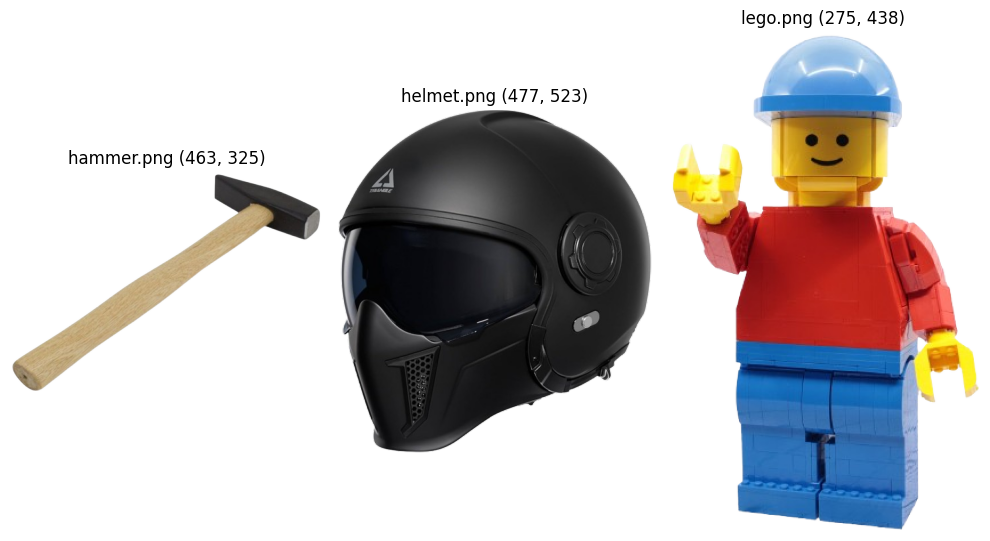

In [3]:
#My obects 
objects = "./objects"
fig, axes = plt.subplots(1, 3, figsize=(10, 10))
objects_images = os.listdir(objects)
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(objects, objects_images[i]))
    ax.imshow(img)
    ax.set_title(f"{objects_images[i]} {img.size}")  # Optional: show the image filename as the title
    ax.axis('off')  # Hide the axis
plt.tight_layout()
plt.show()

In [24]:
from PIL import Image

def scale_down_to_fit(obj_img, target_size=(224, 224), scale_factor=0.3):
    obj_w, obj_h = obj_img.size
    max_w, max_h = target_size

    # Calculate the scaling factor to maintain aspect ratio
    initial_scaling = min(max_w / obj_w, max_h / obj_h)

    # Apply additional scale factor to make the object smaller
    final_scaling = initial_scaling * scale_factor

    # New dimensions after scaling
    new_w = int(obj_w * final_scaling)
    new_h = int(obj_h * final_scaling)

    # Resize the object image
    obj_img = obj_img.resize((new_w, new_h))

    return obj_img

In [55]:
#as we can see that my objects have different size, let us make them all the same size
ObjectsTensors = {}
for image in os.listdir("./objects"):
    img = Image.open(os.path.join(objects, image)).convert("RGB")
    img = transforms.ToTensor()(scale_down_to_fit(img, scale_factor = 0.4))
    ObjectsTensors[image.split('.')[0]] = img



In [56]:
ObjectsTensors.keys()

dict_keys(['hammer', 'helmet', 'lego'])

In [57]:
for k in ObjectsTensors.keys():
    print(ObjectsTensors[k].shape)

torch.Size([3, 62, 89])
torch.Size([3, 89, 81])
torch.Size([3, 89, 56])


In [58]:
def plotImage(tensor ):
    # Convert normalized coordinates to actual pixel values
    img_height, img_width = tensor.shape[1:3]
    
    # Plotting the tensor image and the bounding box
    fig, ax = plt.subplots(1)
    permutedtensor= tensor.permute(1,2,0)
    # Convert the tensor to a NumPy array for plotting
    img_np = permutedtensor.numpy()
    
    # Show the image
    ax.imshow(img_np)
    plt.axis('off')  # Optionally hide the axes
    plt.show()

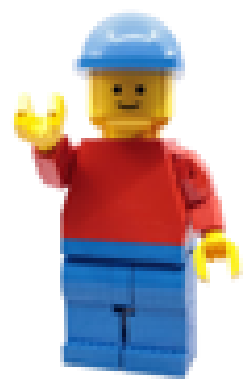

In [59]:
plotImage(ObjectsTensors["lego"])

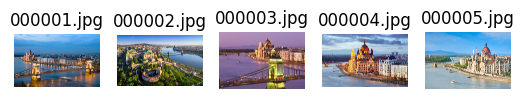

In [3]:
#now let us display some background images 
def displaysomeimages(image_dir):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import os
    # Filter out only image files (if needed)
    image_files = os.listdir(image_dir)
    image_files = [file for file in image_files if file.endswith(".jpg") or file.endswith(".png")]
    image_dir 
    # Display each image with its filename
    count=0 
    for i, image_file in enumerate(image_files):
        #displaying maximum of 3 images
        if(count==5):
            break;
        # Create a subplot for each image
        plt.subplot(1, 5, i+1)
        
        # Load and display the image
        img = mpimg.imread(os.path.join(image_dir, image_file))
        plt.imshow(img)
        plt.axis('off')  # Turn off axis

        # Display filename as title
        plt.title(image_file)
        count=count+1; 
    # Show the plot with all images
    plt.show()

displaysomeimages('background')

<h1>Dataset Creation</h1>

In [17]:
import os
from PIL import Image
from torchvision import transforms
import random

# Define paths
backgrounds_path = 'background'
training_images_path = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images'
validation_images_path = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/validation/images'
test_images_path = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/testing/images'



# Define a more extensive set of transformations for data augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomPerspective(distortion_scale=0.4, p=0.2),
    transforms.RandomResizedCrop(800, scale=(0.8, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    ], p=0.5)
])
 
# Create directories if they don't exist
os.makedirs(training_images_path, exist_ok=True)
os.makedirs(validation_images_path, exist_ok=True)
os.makedirs(test_images_path, exist_ok=True) 

In [19]:
def process_and_augment_images(source_path, target_path, num_images):
    file_names = os.listdir(source_path)
    if(source_path=='background'):
        file_names=file_names[1:]
    processed_count = 0
    while processed_count < num_images:
        for file_name in file_names:
            if processed_count >= num_images:
                break
            try:
                with Image.open(os.path.join(source_path, file_name)).convert("RGB") as img:
                    # Apply the transformations
                    augmented_img = data_transforms(img)
                    augmented_img.save(os.path.join(target_path, f'{processed_count}.png'))
                    processed_count += 1
            except Exception as e:
                print(f'Error processing {file_name}: {e}')


# Define paths
backgrounds_path = 'background'    
training_background_images = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/training'
validation_background_images = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/validation'
testing_background_images = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/testing'


# Create directories if they don't exist
os.makedirs(training_background_images, exist_ok=True)
os.makedirs(validation_background_images, exist_ok=True)
os.makedirs(testing_background_images, exist_ok=True)


#Process and augment images for each dataset
process_and_augment_images(backgrounds_path, training_background_images, 5000)
process_and_augment_images(backgrounds_path, validation_background_images, 1000)
process_and_augment_images(backgrounds_path, testing_background_images, 1000)

In [28]:
# Function to generate random coordinates for object placement
def generate_random_coordinates(background_width, background_height, object_width, object_height):
    x = random.randint(0, background_width - object_width)
    y = random.randint(0, background_height - object_height)
    return x, y

In [41]:
import os
import random
from PIL import Image
import numpy as np

# Set paths
backgrounds_dir = 'background/'
objects_dir = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/objects/'
dataset_dir = 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset'

def createtheimageslabels (backgrounds_dir, dataset_dir, img_size = 224):
    images_dir = os.path.join(dataset_dir, 'images/')
    labels_dir = os.path.join(dataset_dir, 'labels/')
    # Define classes and their corresponding YOLO class IDs
    classes = ['hammmer', 'helmet', 'lego']
    yolo_class_ids = [0, 1, 2]  # YOLO class IDs corresponding to classes
    # Create dataset directory structure
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    # Load background and object images
    backgrounds = [os.path.join(backgrounds_dir, file) for file in os.listdir(backgrounds_dir)]
    objects = [os.path.join(objects_dir, file) for file in os.listdir(objects_dir)]
    # Iterate over backgrounds
    for background_path in backgrounds:
        #PIL Image
        background = Image.open(background_path).convert("RGBA")
        background_width, background_height = background.size
       
        # Randomly select an object image
        ran_index= random.randint(0, 2)
        object_path = objects[ran_index]
        object_img = Image.open(object_path).convert("RGBA")
        #hon sar maa3na el object mtl ma huwe, so khallina na3melo resize w nelz2o 3al soora w nekhod el bb tb3o
        object_width, object_height = object_img.size
        random_scale = random.choice([  0.7, 0.8, 0.9 , 1 ])
        object_img = scale_down_to_fit(object_img, target_size=(224, 224), scale_factor=random_scale)
        object_width, object_height = object_img.size
        if (object_width >= background_width or object_height >= background_height):
            continue; 
        # Paste object onto background
        x, y = generate_random_coordinates(background_width, background_height, object_width, object_height)
        background.paste(object_img, (x, y),object_img)

        # Save composed image
        image_filename = os.path.basename(background_path)
        composed_image_path = os.path.join(images_dir, image_filename)
        background.save(composed_image_path)

        # Calculate bounding box coordinates
        xmin = x
        ymin = y
        xmax = x + object_width
        ymax = y + object_height


        # Calculate YOLO format coordinates
        image_width, image_height = background.size
        yolo_x = (xmin + xmax) / (2 * image_width)
        yolo_y = (ymin + ymax) / (2 * image_height)
        yolo_w = (xmax - xmin) / image_width
        yolo_h = (ymax - ymin) / image_height

        # Determine the class of the object
        class_index = ran_index
        class_name = classes[ran_index]
        yolo_class_id = yolo_class_ids[class_index]

        # Save bounding box coordinates to label file in YOLO format
        label_filename = os.path.splitext(image_filename)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_filename)
        with open(label_path, 'w') as f:
            f.write(f'{yolo_class_id} {yolo_x} {yolo_y} {yolo_w} {yolo_h}')

    print("Dataset creation completed.")

In [42]:
training_backgrounds='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/training'
testing_backgrounds='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/testing'
validation_backgrounds='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/transformed_backgrounds/validation'
training_dataset= 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training'
validation_dataset= 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/validation'
testing_dataset= 'D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/testing'

createtheimageslabels(testing_backgrounds,testing_dataset)
createtheimageslabels(validation_backgrounds,validation_dataset)
createtheimageslabels(training_backgrounds,training_dataset)

Dataset creation completed.
Dataset creation completed.
Dataset creation completed.


<h1>Preparing the Custom Dataset</h1>

In [9]:
training_dataset_images= "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images"
training_dataset_labels= "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/labels"


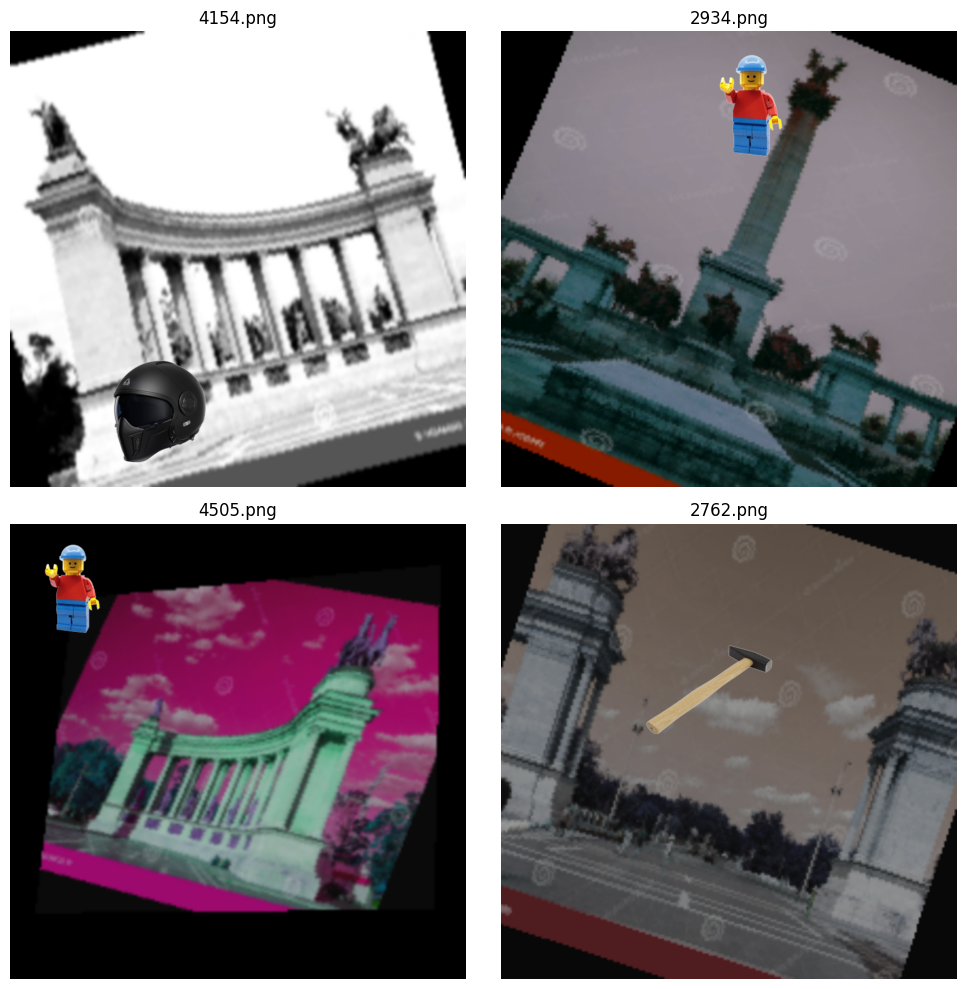

In [10]:
#here are some of the images 
image_files= [f for f in os.listdir(training_dataset_images) if f.endswith(('.png', '.jpg', '.jpeg'))]
# Randomly select 4 images
random_images = random.sample(image_files, 4)
# Set up a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
# Display each image in the grid
for i, ax in enumerate(axes.flat):
    img = Image.open(os.path.join(training_dataset_images, random_images[i]))
    ax.imshow(img)
    ax.set_title(random_images[i])  # Optional: show the image filename as the title
    ax.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [16]:
import matplotlib.patches as patches
def plotImageAndBB(tensor , class_id, x_center, y_center, box_width, box_height):
    # Convert normalized coordinates to actual pixel values
    img_height, img_width = tensor.shape[1:3]
    x_center *= img_width
    y_center *= img_height
    box_width *= img_width
    box_height *= img_height
    # Convert from (center x, center y, width, height) to (top-left x, top-left y, width, height)
    x_min = x_center - box_width / 2
    y_min = y_center - box_height / 2
    
    # Plotting the tensor image and the bounding box
    fig, ax = plt.subplots(1)
    permutedtensor= tensor.permute(1,2,0)
    # Convert the tensor to a NumPy array for plotting
    img_np = permutedtensor.numpy()
    
    # Show the image
    ax.imshow(img_np)
    
    # Create a Rectangle patch (top-left x, top-left y, width, height)
    rect = patches.Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='r', facecolor='none')
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Show the plot with the bounding box
    plt.axis('off')  # Optionally hide the axes
    plt.show()

In [17]:
#with bounding boxes 
def takeImage(trainingpath, imgname, resize= None):
    name= imgname + ".png"
    label = imgname + ".txt"
    imgpath= os.path.join(trainingpath , "images",  name)
    textpath = os.path.join(trainingpath, "labels", label)
    img = Image.open(imgpath)
    imgTensor = transforms.ToTensor()(img)
    if(resize):
        imgTensor = transforms.Resize((resize,resize))(imgTensor)
    with open(textpath, "r") as k:
        x=k.read()
    class_id, x_center, y_center, box_width, box_height = map(float, x.split(" "))
    plotImageAndBB( imgTensor, class_id, x_center, y_center, box_width, box_height )
training_dataset = "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training"

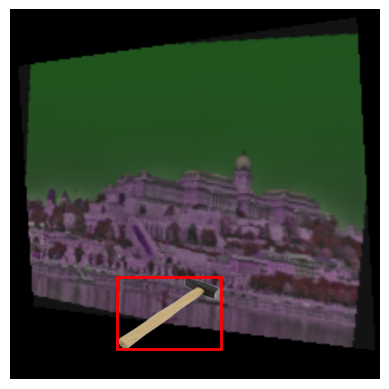

In [13]:
takeImage(training_dataset, "80" )

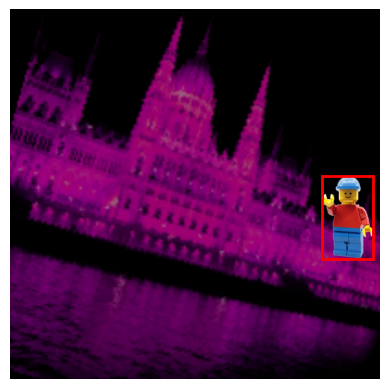

In [14]:
takeImage(training_dataset, "2601" )

In [13]:
with open(os.path.join(training_dataset_labels, "2601.txt" ), "r") as f:
    k=f.read()
print(k)

2 0.9125 0.561875 0.14 0.22375


class x_center y_center width height

In [19]:
import os 
from torch.utils.data import Dataset 

class CustomObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        """
        Args:
            root_dir (string): Directory with 'images' and 'labels' subfolders.
            transforms (callable, optional): Optional transforms to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transforms = transforms
        self.images_dir = os.path.join(root_dir, 'images')
        self.labels_dir = os.path.join(root_dir, 'labels')
        self.image_files = sorted(os.listdir(self.images_dir))  # List of image filenames

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        # Load the corresponding label (bounding box and class)
        label_filename = os.path.splitext(image_filename)[0] + ".txt"
        label_path = os.path.join(self.labels_dir, label_filename)

        boxes = []
        labels = []

        with open(label_path, "r") as file:
            for line in file:
                # Parse the label line
                label_data = line.strip().split()
                class_id = int(label_data[0])  # The class (first number)
                x_center, y_center, width, height = map(float, label_data[1:])
                '''
                # Convert normalized bbox (x_center, y_center, width, height) to (x_min, y_min, x_max, y_max)
                image_width, image_height = image.size
                x_min = (x_center - width / 2) * image_width
                y_min = (y_center - height / 2) * image_height
                x_max = (x_center + width / 2) * image_width
                y_max = (y_center + height / 2) * image_height
                '''
                boxes.append([x_center, y_center, width, height])
                labels.append(class_id)  # Append the class label

        # Convert to torch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create the target dictionary as required by Faster R-CNN
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        # Apply any data transformations (e.g., resizing, augmentation)
        if self.transforms:
            image = self.transforms(image)

        return image, target



In [20]:
# Define any data transformations (e.g., resizing, normalization)
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
 

# Create dataset instances
train_dataset = CustomObjectDetectionDataset(root_dir='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training', transforms=data_transforms)
val_dataset = CustomObjectDetectionDataset(root_dir='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/validation', transforms=data_transforms)
test_dataset = CustomObjectDetectionDataset(root_dir='D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/testing', transforms=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)




<h1>YOLO</h1>

In [2]:
from ultralytics import YOLO

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


In [20]:
model= YOLO("yolov8n.pt")
model.to(device)
results = model.train(data= "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/data.yaml",epochs=10, imgsz=224, batch=16, project="Labor", device=device, name="Test1" )

New https://pypi.org/project/ultralytics/8.3.21 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=Labor, name=Test12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_con

D:\Anaconda\envs\test\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 


train: Scanning D:\Msc_Data_Science_1\Semester 3\DND practice\assignment 1\dataset\training\labels.cache... 5000 images
val: Scanning D:\Msc_Data_Science_1\Semester 3\DND practice\assignment 1\dataset\validation\labels.cache... 1000 images


Plotting labels to Labor\Test12\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to Labor\Test12
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.621G     0.6324      1.143     0.8793          8        224: 100%|██████████| 313/313 [01:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08


                   all       1000       1000      0.758    0.00811     0.0127     0.0109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.614G     0.5249      0.534     0.8468          8        224: 100%|██████████| 313/313 [01:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08

                   all       1000       1000     0.0956    0.00811     0.0556     0.0509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.635G     0.4685     0.4346     0.8378          8        224: 100%|██████████| 313/313 [01:23<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10

                   all       1000       1000      0.216    0.00607      0.114      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.635G     0.4148     0.3709      0.829          8        224: 100%|██████████| 313/313 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11


                   all       1000       1000       0.25    0.00291      0.127      0.118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.635G     0.3701     0.3239     0.8171          8        224: 100%|██████████| 313/313 [01:28<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11

                   all       1000       1000      0.556    0.00303       0.28      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.614G     0.3376     0.2931     0.8123          8        224: 100%|██████████| 313/313 [01:35<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:09

                   all       1000       1000      0.333    0.00291      0.168      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.635G      0.307     0.2661     0.8077          8        224: 100%|██████████| 313/313 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10

                   all       1000       1000      0.333    0.00291      0.168      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.635G     0.2945     0.2518     0.8061          8        224: 100%|██████████| 313/313 [01:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11


                   all       1000       1000      0.333    0.00291      0.168      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.635G     0.2631     0.2301     0.7979          7        224: 100%|██████████| 313/313 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:10


                   all       1000       1000      0.333    0.00291      0.168      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.614G     0.2388     0.2126     0.7963          8        224: 100%|██████████| 313/313 [01:29<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:11

                   all       1000       1000      0.333    0.00388      0.169      0.169



10 epochs completed in 0.286 hours.
Optimizer stripped from Labor\Test12\weights\last.pt, 6.2MB
Optimizer stripped from Labor\Test12\weights\best.pt, 6.2MB

Validating Labor\Test12\weights\best.pt...
Ultralytics YOLOv8.2.28  Python-3.11.9 torch-2.3.0 CUDA:0 (NVIDIA GeForce MX450, 2048MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:08


                   all       1000       1000      0.556    0.00303       0.28      0.274
                hammer        344        344      0.667    0.00581      0.337       0.32
                helmet        352        352          0          0          0          0
                  lego        304        304          1    0.00329      0.502      0.502
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to Labor\Test12


In [5]:
model= YOLO("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/Labor/Test12/weights/best.pt")

In [6]:
testresults = model.val(data= "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/data.yaml")  # Run validation/test to measure accuracy and mAP

Ultralytics YOLOv8.2.28  Python-3.11.9 torch-2.3.0 CUDA:0 (NVIDIA GeForce MX450, 2048MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Msc_Data_Science_1\Semester 3\DND practice\assignment 1\dataset\validation\labels.cache... 1000 images
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:11


                   all       1000       1000      0.999          1      0.995      0.977
                hammer        344        344          1      0.999      0.995      0.952
                helmet        352        352      0.999          1      0.995      0.995
                  lego        304        304      0.999          1      0.995      0.983
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs\detect\val


<h1>Now Let us Build Our Own Model</h1>

Model architecture: 
the model will use a pretrained vgg16 NN for feature extraction and then we'll do box regression and classification 
we might check other approaches and do some edits to have better results. 


In [4]:
torch.cuda.empty_cache()

In [2]:
model = torchvision.models.vgg16(pretrained= True)
model = model.features
model.to(device)

D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\test\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NameError: name 'device' is not defined

In [36]:
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/1200.png").convert("RGB").resize((224,224))

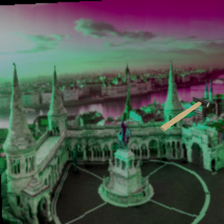

In [37]:
img

In [38]:
img.size

(224, 224)

In [39]:
# Convert PIL image to tensor
img = transforms.ToTensor()(img)

# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)

In [46]:
img.shape
img= img.to(device)

In [48]:
#now pass it to the vgg16 and check the feature maps 
model.eval()
model= model.to(device)
with torch.no_grad():
    output = model(img)

In [50]:
output.shape

torch.Size([1, 512, 7, 7])

In [53]:
%matplotlib inline

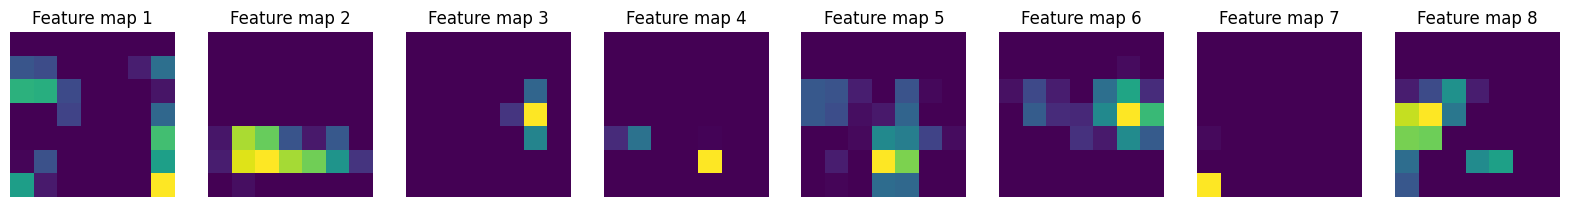

In [54]:
num_feature_maps_to_show = min(8, feature_maps.shape[0])  # Choose how many feature maps you want to visualize
feature_maps = output.squeeze(0)

# Plotting the feature maps
plt.figure(figsize=(20, 10))  # Create a figure for the subplots
for i in range(num_feature_maps_to_show):
    plt.subplot(1, num_feature_maps_to_show, i + 1)
    plt.imshow(feature_maps[i].cpu().numpy(), cmap='viridis')  # Convert to numpy and plot
    plt.axis('off')  # Turn off axis labels for clarity
    plt.title(f"Feature map {i + 1}")

plt.show()  # Display the feature maps

In [2]:
import torch.optim as optim

In [33]:
import torch.nn as nn
import torch.nn.functional as F

class CustomModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CustomModel, self).__init__()
        self.backbone= torchvision.models.vgg16(pretrained= True).features 
        # Freeze the weights of the VGG16 backbone
        for param in self.backbone.parameters():
            param.requires_grad = False  # This freezes the weights
        # Detection layers
        self.flatten = nn.Flatten()
        self.classification = nn.Sequential(
            nn.Linear(512*7*7, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
        self.bbox_regression = nn.Sequential(
            nn.Linear(512*7*7, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)

        class_probs = self.classification(features)
        bbox_regression = self.bbox_regression(features)
        return class_probs, bbox_regression


In [34]:
model = CustomModel( num_classes=3)

In [32]:
model

CustomModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [37]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score


In [39]:
# Function to calculate IoU with bounding boxes in (x1, y1, width, height) format
def calculate_iou(box1, box2):
    # Convert (x_center, y_center, width, height) to (x1, y1, x2, y2)
    def convert_to_corners(box):
        x_center, y_center, width, height = box
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        return (x1, y1, x2, y2)

    # Convert both boxes
    x1_box1, y1_box1, x2_box1, y2_box1 = convert_to_corners(box1)
    x1_box2, y1_box2, x2_box2, y2_box2 = convert_to_corners(box2)

    # Calculate intersection coordinates
    xi1 = max(x1_box1, x1_box2)
    yi1 = max(y1_box1, y1_box2)
    xi2 = min(x2_box1, x2_box2)
    yi2 = min(y2_box1, y2_box2)

    # Calculate intersection area
    intersection_width = max(0, xi2 - xi1)
    intersection_height = max(0, yi2 - yi1)
    intersection_area = intersection_width * intersection_height

    # Calculate areas of each box
    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    # Calculate union area
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

def train2(model, train_loader, val_loader, num_epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Define loss functions
    classification_criterion = nn.CrossEntropyLoss()
    regression_criterion = nn.SmoothL1Loss()
    
    # Lists to track losses and mAP
    train_losses = []
    val_losses = []
    train_classification_losses = []
    train_regression_losses = []
    mAPs = []  # Track mAP@50 per epoch

    # Early stopping variables
    best_val_loss = np.inf
    epochs_no_improve = 0

    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_classification_loss = 0.0
        train_regression_loss = 0.0

        # Progress bar for training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, targets in train_loader:
                images = images.to(device)
                labels = targets['labels'].to(device).squeeze()
                bbox_list = targets['boxes'].to(device).squeeze(1)

                optimizer.zero_grad()
                
                # Forward pass
                class_probs, bbox_regression = model(images)

                # Calculate losses
                classification_loss = classification_criterion(class_probs, labels)
                regression_loss = regression_criterion(bbox_regression, bbox_list)

                loss = classification_loss + regression_loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()

                # Update losses
                train_loss += loss.item() * images.size(0)
                train_classification_loss += classification_loss.item() * images.size(0)
                train_regression_loss += regression_loss.item() * images.size(0)

                # Update the progress bar
                pbar.set_postfix({
                    'train_loss': train_loss / (len(train_loader.dataset)),
                    'class_loss': train_classification_loss / (len(train_loader.dataset)),
                    'reg_loss': train_regression_loss / (len(train_loader.dataset))
                })
                pbar.update(1)

        # Calculate average training losses
        train_loss /= len(train_loader.dataset)
        train_classification_loss /= len(train_loader.dataset)
        train_regression_loss /= len(train_loader.dataset)

        # Append losses to lists
        train_losses.append(train_loss)
        train_classification_losses.append(train_classification_loss)
        train_regression_losses.append(train_regression_loss)

        # Validation phase for mAP calculation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_scores = []
        all_iou_matches = []
        with torch.no_grad():
            for image, target in val_loader:
                image = image.to(device)
                labels = target['labels'].to(device).squeeze()
                bbox_list = target['boxes'].to(device).squeeze(1)

                # Forward pass
                class_probs, bbox_regression = model(image)
                classification_loss = classification_criterion(class_probs, labels)
                regression_loss = regression_criterion(bbox_regression, bbox_list)

                # Total loss
                loss = classification_loss + regression_loss
                val_loss += loss.item() * image.size(0)

                # mAP@50 calculation
                pred_boxes = bbox_regression.cpu()
                gt_boxes = bbox_list.cpu()
                for i in range(len(pred_boxes)):
                    pred_box = pred_boxes[i]
                    gt_box = gt_boxes[i]
                    iou = calculate_iou(pred_box, gt_box)
                    
                    all_labels.append(labels[i].item())
                    all_scores.append(class_probs[i].max().item())  # Highest probability score for predicted class
                    all_iou_matches.append(iou >= 0.5)  # True if IoU >= 0.5

        # Calculate mAP@50
        precision, recall, _ = precision_recall_curve(all_iou_matches, all_scores)
        average_precision = average_precision_score(all_iou_matches, all_scores)
        mAPs.append(average_precision)
        
        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Classification Loss: {train_classification_loss:.4f}, '
              f'Regression Loss: {train_regression_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')

        # Update learning rate scheduler
        scheduler.step(val_loss)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plot mAP
    plt.figure(figsize=(10, 5))
    plt.plot(mAPs, label='mAP@50')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@50')
    plt.title('Mean Average Precision (mAP@50) Over Epochs')
    plt.legend()
    plt.show()
    print('Training complete.')

    return model, train_losses, val_losses

Epoch 1/5: 100%|██████████| 313/313 [09:30<00:00,  1.82s/batch, train_loss=0.0806, class_loss=0.0772, reg_loss=0.00338]


Epoch [1/5], Train Loss: 0.0806, Classification Loss: 0.0772, Regression Loss: 0.0034, Val Loss: 0.0834


Epoch 2/5: 100%|██████████| 313/313 [07:59<00:00,  1.53s/batch, train_loss=0.0535, class_loss=0.0509, reg_loss=0.00261]


Epoch [2/5], Train Loss: 0.0535, Classification Loss: 0.0509, Regression Loss: 0.0026, Val Loss: 0.0427


Epoch 3/5: 100%|██████████| 313/313 [08:03<00:00,  1.54s/batch, train_loss=0.0433, class_loss=0.0411, reg_loss=0.00227]


Epoch [3/5], Train Loss: 0.0433, Classification Loss: 0.0411, Regression Loss: 0.0023, Val Loss: 0.0503


Epoch 4/5: 100%|████████████| 313/313 [07:58<00:00,  1.53s/batch, train_loss=0.031, class_loss=0.029, reg_loss=0.00206]


Epoch [4/5], Train Loss: 0.0310, Classification Loss: 0.0290, Regression Loss: 0.0021, Val Loss: 0.0903


Epoch 5/5: 100%|████████████| 313/313 [08:03<00:00,  1.54s/batch, train_loss=0.0228, class_loss=0.0208, reg_loss=0.002]


Epoch [5/5], Train Loss: 0.0228, Classification Loss: 0.0208, Regression Loss: 0.0020, Val Loss: 0.0490


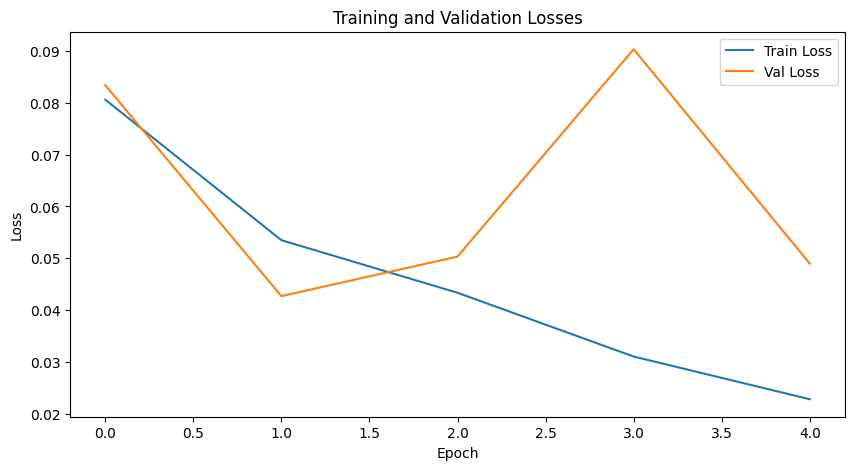

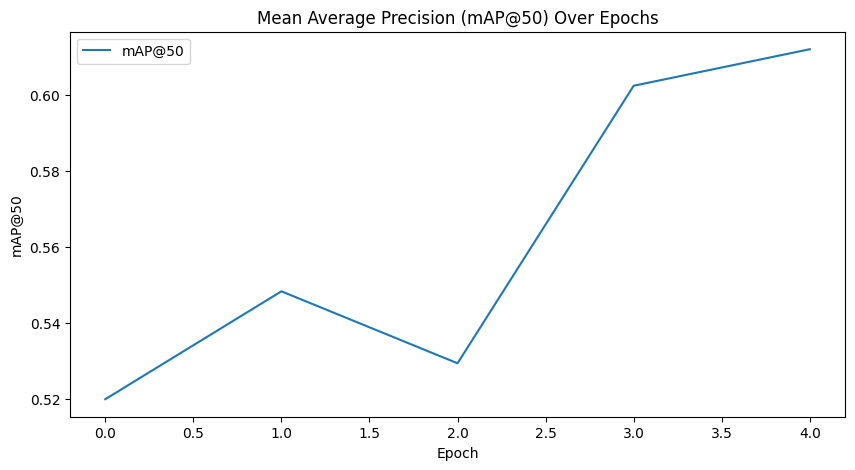

Training complete.


In [40]:
trained_model ,train_losses, val_losses = train2(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [71]:
torch.save(trained_model.state_dict(), 'model_weights1.pth')

In [28]:
trained_model ,train_losses2, val_losses2 = train2(model=trained_model, train_loader=train_loader, val_loader=val_loader, num_epochs=5)


NameError: name 'trained_model' is not defined

In [ ]:
torch.save(trained_model.state_dict(), 'model_weights2.pth')

In [ ]:
trained_model ,train_losses3, val_losses3 = train2(model=trained_model, train_loader=train_loader, val_loader=val_loader, num_epochs=5)

In [ ]:
torch.save(trained_model.state_dict(), 'model_weights3.pth')

In [ ]:
trained_model ,train_losses4, val_losses4 = train2(model=trained_model, train_loader=train_loader, val_loader=val_loader, num_epochs=3)

In [ ]:
torch.save(trained_model.state_dict(), 'model_weights4.pth')

tensor([[-4.9290, -5.4762,  6.8840]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.4205, 0.3187, 0.1734, 0.2310], device='cuda:0',
       grad_fn=<SelectBackward0>)


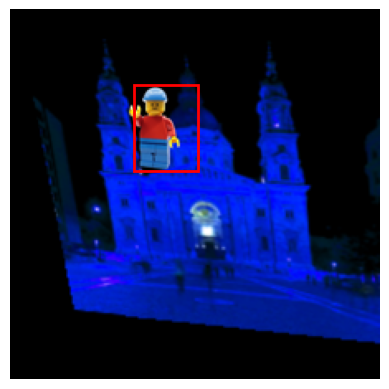

In [41]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/4467.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
img=transforms.Resize((224,224))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model(img)
print(class_probs)
print(bbox_regression[0])
x,y,h,w= bbox_regression[0].tolist()
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)

In [42]:
#let us view the true label of the above image 
file_path = "D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/labels/4467.txt"
with open (file_path , 'r')as f:
    output = f.read()
print(output)

2 0.39 0.321875 0.14 0.22375


tensor([[-1.2681,  0.7120, -1.0486]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.3704, 0.4725, 0.2139, 0.2068], device='cuda:0',
       grad_fn=<SelectBackward0>)


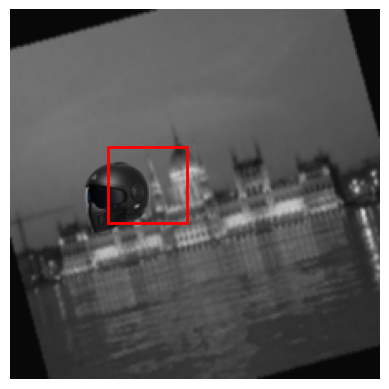

In [43]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/1432.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model(img)
print(class_probs)
x,y,h,w= bbox_regression[0].tolist()
print(bbox_regression[0])
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)

tensor([[-0.4745,  1.3644, -2.7812]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.7769, 0.6734, 0.2529, 0.2191], device='cuda:0',
       grad_fn=<SelectBackward0>)


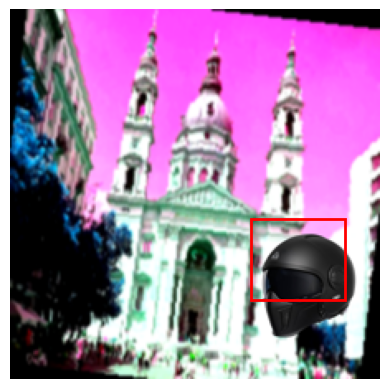

In [44]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/1122.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
img=transforms.Resize((224,224))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model(img)
print(class_probs)
x,y,h,w= bbox_regression[0].tolist()
print(bbox_regression[0])
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)

<h1>Calculating the mAP</h1>

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Define loss functions
classification_criterion = nn.CrossEntropyLoss()
regression_criterion = nn.SmoothL1Loss()
# Testing phase for mAP calculation
trained_model.eval()
test_loss = 0.0
all_labels = []
all_scores = []
all_iou_matches = []

with torch.no_grad():
    for image, target in test_loader:
        image = image.to(device)
        labels = target['labels'].to(device).squeeze()
        bbox_list = target['boxes'].to(device).squeeze(1)

        # Forward pass
        class_probs, bbox_regression = trained_model(image)
        classification_loss = classification_criterion(class_probs, labels)
        regression_loss = regression_criterion(bbox_regression, bbox_list)

        # Total loss
        loss = classification_loss + regression_loss
        test_loss += loss.item() * image.size(0)

        # mAP@50 calculation
        pred_boxes = bbox_regression.cpu()
        gt_boxes = bbox_list.cpu()
        for i in range(len(pred_boxes)):
            pred_box = pred_boxes[i]
            gt_box = gt_boxes[i]
            iou = calculate_iou(pred_box, gt_box)
            
            # Track information for mAP calculation
            all_labels.append(labels[i].item())  # Actual class label
            all_scores.append(class_probs[i].max().item())  # Highest probability score for predicted class
            all_iou_matches.append(iou >= 0.5)  # True if IoU >= 0.5

# Calculate mAP@50
def calculate_map(all_labels, all_scores, all_iou_matches, iou_threshold=0.5):
    """
    Calculates mAP for each class and returns the mean of these values.

    Parameters:
    - all_labels: List of true class labels for each prediction.
    - all_scores: List of confidence scores for each prediction.
    - all_iou_matches: List of boolean values indicating if each prediction has IoU >= threshold.

    Returns:
    - mAP: Mean Average Precision across all classes.
    - class_aps: Dictionary with AP for each class.
    """
    class_aps = {}
    unique_classes = set(all_labels)  # Identify all unique classes in the labels

    for cls in unique_classes:
        # Filter by current class
        indices = [i for i, label in enumerate(all_labels) if label == cls]
        cls_scores = [all_scores[i] for i in indices]
        cls_iou_matches = [all_iou_matches[i] for i in indices]

        # Calculate average precision for the current class
        if len(cls_scores) > 0:
            ap = average_precision_score(cls_iou_matches, cls_scores)
            class_aps[cls] = ap

    # Calculate mean of APs for all classes
    mAP = np.mean(list(class_aps.values()))
    return mAP, class_aps

# Use the function to calculate mAP@50
mAP, class_aps = calculate_map(all_labels, all_scores, all_iou_matches)

# Print results
print(f'mAP@50: {mAP:.4f}')
for cls, ap in class_aps.items():
    print(f'AP for class {cls}: {ap:.4f}')

# Calculate average test loss
test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}, '
      f'Classification Loss: {classification_loss:.4f}, '
      f'Regression Loss: {regression_loss:.4f}')

mAP@50: 0.5182
AP for class 0: 0.3994
AP for class 1: 0.6427
AP for class 2: 0.5125
Test Loss: 0.0441, Classification Loss: 0.0006, Regression Loss: 0.0015


<h3>Classification</h3>

In [101]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import torch

def compute_map(model, test_loader, iou_threshold=0.5, num_classes=3):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    # Lists to store ground truth and predictions
    all_gt_boxes = []
    all_pred_boxes = []
    all_gt_labels = []
    all_pred_scores = []
    all_pred_labels = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            labels = targets['labels'].to(device)
            boxes = targets['boxes'].to(device)

            # Forward pass
            pred_class_probs, pred_boxes = model(images)

            # Process predictions (apply softmax to get probabilities)
            pred_probs = torch.softmax(pred_class_probs, dim=1)
            pred_scores, pred_labels = torch.max(pred_probs, dim=1)

            # Convert data to lists for easier processing
            all_gt_boxes.extend(boxes.cpu().numpy())
            all_gt_labels.extend(labels.cpu().numpy())
            all_pred_boxes.extend(pred_boxes.cpu().numpy())
            all_pred_scores.extend(pred_scores.cpu().numpy())
            all_pred_labels.extend(pred_labels.cpu().numpy())

    # Calculate mAP for each class
    ap_per_class = []
    for cls in range(num_classes):
        # Generate binary ground truth and predictions for the current class
        gt_class = np.array([1 if label == cls else 0 for label in all_gt_labels])
        pred_class_scores = np.array([score if label == cls else 0 for score, label in zip(all_pred_scores, all_pred_labels)])

        # Check if there are any predictions for the class
        if gt_class.sum() > 0 and pred_class_scores.sum() > 0:
            precision, recall, _ = precision_recall_curve(gt_class, pred_class_scores)
            ap = average_precision_score(gt_class, pred_class_scores)
        else:
            ap = 0.0
        ap_per_class.append(ap)

    # Calculate the mean of all APs to get mAP
    mean_ap = np.mean(ap_per_class)
    print(f'mAP: {mean_ap:.4f}')

    return mean_ap, ap_per_class


In [102]:
mAp , ap_per_class= compute_map(trained_model, test_loader,  iou_threshold=0.5, num_classes=3)

mAP: 0.9783


In [103]:
mAp

0.9782683460467648

In [104]:
ap_per_class

[0.9839137113549798, 0.9909145968651178, 0.9599767299201966]

<h1>Implementing Early Stopping</h1>

In [48]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [6]:
EarlyStopping = EarlyStopping()

In [49]:
# Function to calculate IoU with bounding boxes in (x1, y1, width, height) format
def calculate_iou(box1, box2):
    # Convert (x_center, y_center, width, height) to (x1, y1, x2, y2)
    def convert_to_corners(box):
        x_center, y_center, width, height = box
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        return (x1, y1, x2, y2)

    # Convert both boxes
    x1_box1, y1_box1, x2_box1, y2_box1 = convert_to_corners(box1)
    x1_box2, y1_box2, x2_box2, y2_box2 = convert_to_corners(box2)

    # Calculate intersection coordinates
    xi1 = max(x1_box1, x1_box2)
    yi1 = max(y1_box1, y1_box2)
    xi2 = min(x2_box1, x2_box2)
    yi2 = min(y2_box1, y2_box2)

    # Calculate intersection area
    intersection_width = max(0, xi2 - xi1)
    intersection_height = max(0, yi2 - yi1)
    intersection_area = intersection_width * intersection_height

    # Calculate areas of each box
    area_box1 = (x2_box1 - x1_box1) * (y2_box1 - y1_box1)
    area_box2 = (x2_box2 - x1_box2) * (y2_box2 - y1_box2)

    # Calculate union area
    union_area = area_box1 + area_box2 - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou

def train2(model, train_loader, val_loader, num_epochs=2):
    device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.005)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3)

    # Define loss functions
    classification_criterion = nn.CrossEntropyLoss()
    regression_criterion = nn.SmoothL1Loss()
    
    # Lists to track losses and mAP
    train_losses = []
    val_losses = []
    train_classification_losses = []
    train_regression_losses = []
    mAPs = []  # Track mAP@50 per epoch

    # Initialize early stopping
    early_stopping = EarlyStopping(tolerance=5, min_delta=0)
    best_val_loss = float('inf')  # Initialize to track the best validation loss
    best_model_state = None  # Initialize to store the best model state

    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_classification_loss = 0.0
        train_regression_loss = 0.0

        # Progress bar for training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, targets in train_loader:
                images = images.to(device)
                labels = targets['labels'].to(device).squeeze()
                bbox_list = targets['boxes'].to(device).squeeze(1)

                optimizer.zero_grad()
                
                # Forward pass
                class_probs, bbox_regression = model(images)

                # Calculate losses
                classification_loss = classification_criterion(class_probs, labels)
                regression_loss = regression_criterion(bbox_regression, bbox_list)

                loss = classification_loss + regression_loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()

                # Update losses
                train_loss += loss.item() * images.size(0)
                train_classification_loss += classification_loss.item() * images.size(0)
                train_regression_loss += regression_loss.item() * images.size(0)

                # Update the progress bar
                pbar.set_postfix({
                    'train_loss': train_loss / (len(train_loader.dataset)),
                    'class_loss': train_classification_loss / (len(train_loader.dataset)),
                    'reg_loss': train_regression_loss / (len(train_loader.dataset))
                })
                pbar.update(1)

        # Calculate average training losses
        train_loss /= len(train_loader.dataset)
        train_classification_loss /= len(train_loader.dataset)
        train_regression_loss /= len(train_loader.dataset)

        # Append losses to lists
        train_losses.append(train_loss)
        train_classification_losses.append(train_classification_loss)
        train_regression_losses.append(train_regression_loss)

        # Validation phase for mAP calculation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_scores = []
        all_iou_matches = []
        with torch.no_grad():
            for image, target in val_loader:
                image = image.to(device)
                labels = target['labels'].to(device).squeeze()
                bbox_list = target['boxes'].to(device).squeeze(1)

                # Forward pass
                class_probs, bbox_regression = model(image)
                classification_loss = classification_criterion(class_probs, labels)
                regression_loss = regression_criterion(bbox_regression, bbox_list)

                # Total loss
                loss = classification_loss + regression_loss
                val_loss += loss.item() * image.size(0)

                # mAP@50 calculation
                pred_boxes = bbox_regression.cpu()
                gt_boxes = bbox_list.cpu()
                for i in range(len(pred_boxes)):
                    pred_box = pred_boxes[i]
                    gt_box = gt_boxes[i]
                    iou = calculate_iou(pred_box, gt_box)
                    
                    all_labels.append(labels[i].item())
                    all_scores.append(class_probs[i].max().item())  # Highest probability score for predicted class
                    all_iou_matches.append(iou >= 0.5)  # True if IoU >= 0.5

        # Calculate mAP@50
        precision, recall, _ = precision_recall_curve(all_iou_matches, all_scores)
        average_precision = average_precision_score(all_iou_matches, all_scores)
        mAPs.append(average_precision)
        
        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, '
              f'Classification Loss: {train_classification_loss:.4f}, '
              f'Regression Loss: {train_regression_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}')
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the state dict of the best model

        # Early stopping check
        early_stopping(train_loss, val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        # Update learning rate scheduler
        scheduler.step(val_loss)

    # Load best model weights after training is complete
    model.load_state_dict(best_model_state)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plot mAP
    plt.figure(figsize=(10, 5))
    plt.plot(mAPs, label='mAP@50')
    plt.xlabel('Epoch')
    plt.ylabel('mAP@50')
    plt.title('Mean Average Precision (mAP@50) Over Epochs')
    plt.legend()
    plt.show()
    print('Training complete.')

    return model, train_losses, val_losses

Epoch 1/30: 100%|█████████| 313/313 [09:47<00:00,  1.88s/batch, train_loss=0.0284, class_loss=0.0265, reg_loss=0.00195]


Epoch [1/30], Train Loss: 0.0284, Classification Loss: 0.0265, Regression Loss: 0.0019, Val Loss: 0.0786


Epoch 2/30: 100%|█████████| 313/313 [07:40<00:00,  1.47s/batch, train_loss=0.0243, class_loss=0.0225, reg_loss=0.00183]


Epoch [2/30], Train Loss: 0.0243, Classification Loss: 0.0225, Regression Loss: 0.0018, Val Loss: 0.0592


Epoch 3/30: 100%|█████████| 313/313 [07:40<00:00,  1.47s/batch, train_loss=0.0201, class_loss=0.0183, reg_loss=0.00181]


Epoch [3/30], Train Loss: 0.0201, Classification Loss: 0.0183, Regression Loss: 0.0018, Val Loss: 0.0769


Epoch 4/30: 100%|█████████| 313/313 [07:38<00:00,  1.47s/batch, train_loss=0.0353, class_loss=0.0335, reg_loss=0.00171]


Epoch [4/30], Train Loss: 0.0353, Classification Loss: 0.0335, Regression Loss: 0.0017, Val Loss: 0.0826


Epoch 5/30: 100%|█████████| 313/313 [07:39<00:00,  1.47s/batch, train_loss=0.0179, class_loss=0.0163, reg_loss=0.00164]


Epoch [5/30], Train Loss: 0.0179, Classification Loss: 0.0163, Regression Loss: 0.0016, Val Loss: 0.0607
Early stopping triggered.


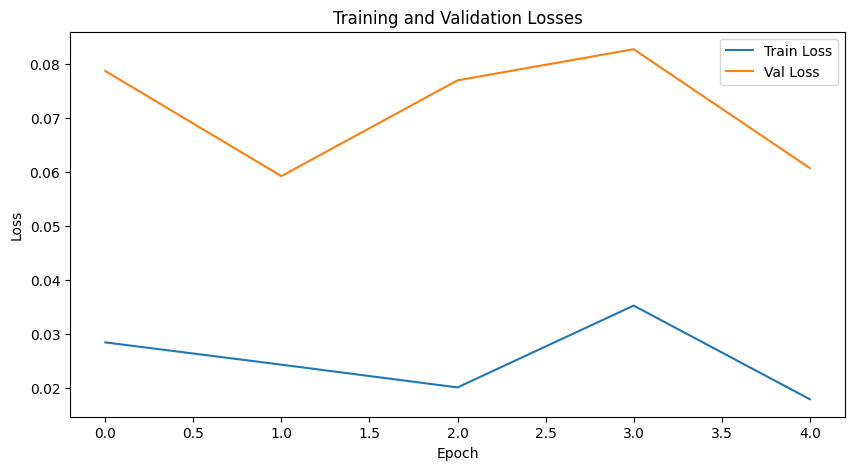

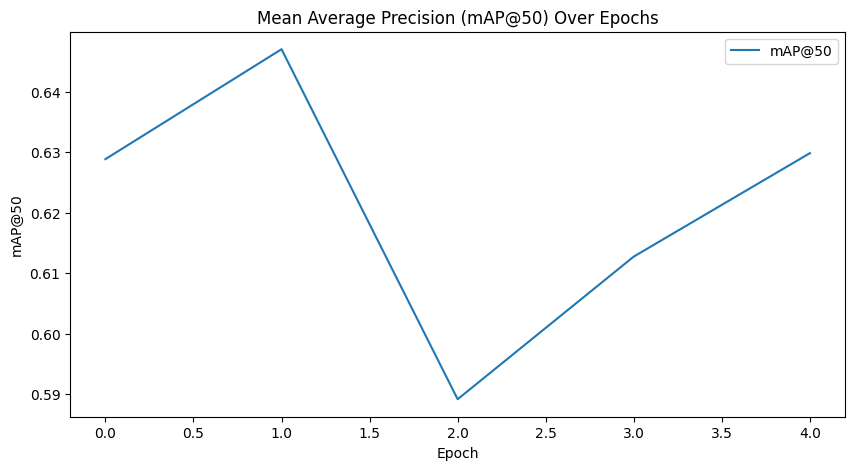

Training complete.


In [50]:
trained_model2 ,train_losses, val_losses = train2(model=trained_model, train_loader=train_loader, val_loader=val_loader, num_epochs=30)

tensor([[-3.9779, -4.4408,  4.7963]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.4090, 0.3525, 0.1566, 0.2166], device='cuda:0',
       grad_fn=<SelectBackward0>)


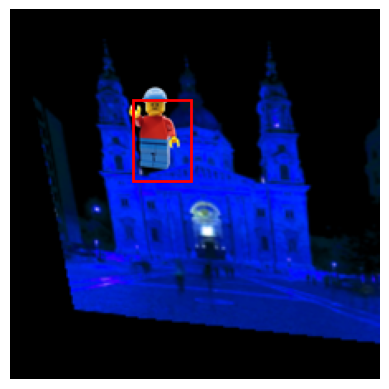

In [53]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/4467.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
img=transforms.Resize((224,224))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model(img)
print(class_probs)
print(bbox_regression[0])
x,y,h,w= bbox_regression[0].tolist()
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)

tensor([[-3.9779, -4.4408,  4.7963]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.4090, 0.3525, 0.1566, 0.2166], device='cuda:0',
       grad_fn=<SelectBackward0>)


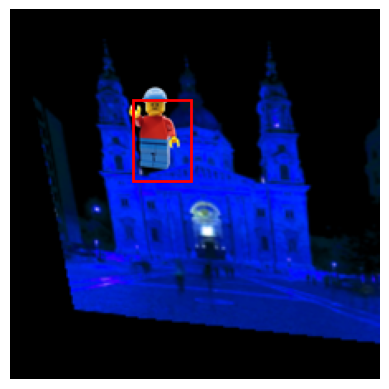

In [54]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/4467.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
img=transforms.Resize((224,224))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model2(img)
print(class_probs)
print(bbox_regression[0])
x,y,h,w= bbox_regression[0].tolist()
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)

tensor([[ 0.8551,  0.6725, -4.2101]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([0.7298, 0.7167, 0.2328, 0.2092], device='cuda:0',
       grad_fn=<SelectBackward0>)


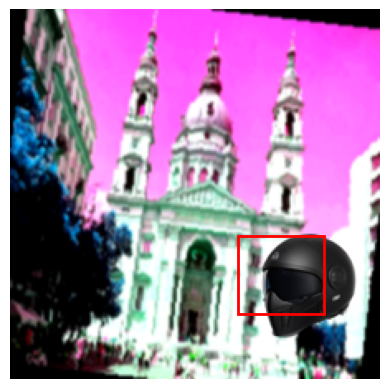

In [55]:
#let us check our model now 
##let us try to take an image and visualize it's feature maps 
#load an image 
img = Image.open("D:/Msc_Data_Science_1/Semester 3/DND practice/assignment 1/dataset/training/images/1122.png").convert("RGB").resize((224,224))
# Convert PIL image to tensor
img = transforms.ToTensor()(img)
img=transforms.Resize((224,224))(img)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add batch dimension (unsqueeze along the first dimension)
img = img.unsqueeze(0)
img=img.to(device)
class_probs, bbox_regression = trained_model2(img)
print(class_probs)
x,y,h,w= bbox_regression[0].tolist()
print(bbox_regression[0])
img= img.squeeze(0) 
img=img.cpu() 
plotImageAndBB(img , 1,x, y, h, w)